In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.basic2 import Basic2
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checkerPmdInit import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Generate a batch of trials

In [2]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, noise = 0.25, wait = [0,0.5])

In [3]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 2,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [0, 1],
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 300,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': [0, 0.5],
 'hi': 1,
 'lo': 0}

{'coherence': 0.8445045236606479, 'noise': 0.25, 'accumulation_mask': 300, 'target_onset': 451, 'checker_onset': 885, 'init_y': array([0.02564503, 0.30857052])}


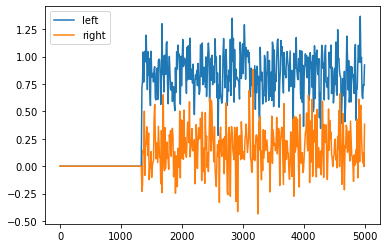

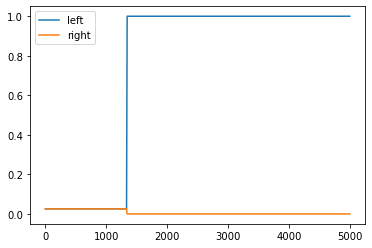

In [7]:
[x, y, mask, allParams] = task.get_trial_batch()

trialNum = 1
# x[1]: left tartet evidence
# x[2]: right target evidence
trialIn = x[trialNum,:,:]
trialOut = y[trialNum,:,:]
trialMask = mask[trialNum,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot input to the model
plt.figure()
plt.plot(time, trialIn[:,0], label = 'left')
plt.plot(time, trialIn[:,1], label = 'right')
plt.legend()

# plot output to the model
plt.figure()
plt.plot(time, trialOut[:,0], label = 'left')
plt.plot(time, trialOut[:,1], label = 'right')
plt.legend()

print(allParams[trialNum])

# Set network parameters

In [10]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.5

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07

In [11]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)


# Set Training params and train

In [14]:
trials = 25000
train_params = {}
train_params['save_weights_path'] =  './init' #"./weights/checkerPmdBasic2InputNoise0.75"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [15]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name =  './init.txt' #"./losses/checkerPmdBasic2InputNoise0.75.txt"
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.199020
Iter 1000, Minibatch Loss= 0.121623
Iter 1500, Minibatch Loss= 0.147277
Iter 2000, Minibatch Loss= 0.147105
Iter 2500, Minibatch Loss= 0.083175
Iter 3000, Minibatch Loss= 0.056118
Iter 3500, Minibatch Loss= 0.052762
Iter 4000, Minibatch Loss= 0.046975
Iter 4500, Minibatch Loss= 0.046284
Iter 5000, Minibatch Loss= 0.042877
Iter 5500, Minibatch Loss= 0.042856
Iter 6000, Minibatch Loss= 0.031776
Iter 6500, Minibatch Loss= 0.033601
Iter 7000, Minibatch Loss= 0.031592
Iter 7500, Minibatch Loss= 0.039219
Iter 8000, Minibatch Loss= 0.037203
Iter 8500, Minibatch Loss= 0.030316
Iter 9000, Minibatch Loss= 0.038664
Iter 9500, Minibatch Loss= 0.028790
Iter 10000, Minibatch Loss= 0.035696
Iter 10500, Minibatch Loss= 0.027452
Iter 11000, Minibatch Loss= 0.042679
Iter 11500, Minibatch Loss= 0.029184
Iter 12000, Minibatch Loss= 0.019001
Iter 12500, Minibatch Loss= 0.020535
I

Text(0.5, 1.0, 'Loss During Training')

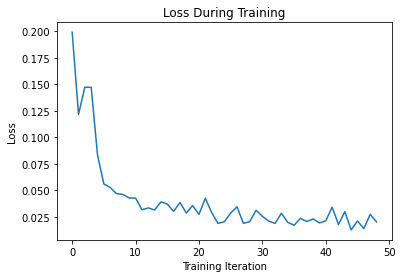

In [16]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

# Test 5000 trials

In [17]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)
decision = np.zeros(trials)
rt = np.zeros(trials)

init_y_left = np.zeros(trials)
init_y_right = np.zeros(trials)

In [18]:
for b in tqdm(range(batches)):
    x, y, m, params = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs

    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index] 
        
        init_y_left[index] = params[i]["init_y"][0] 
        init_y_right[index] = params[i]["init_y"][0]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


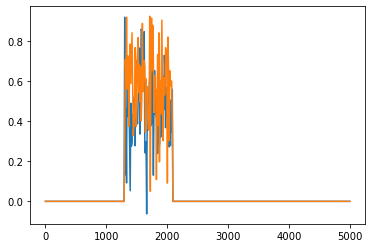

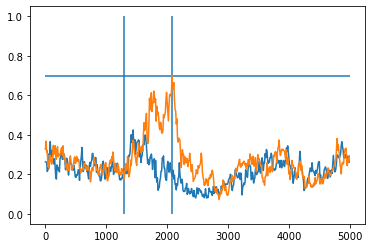

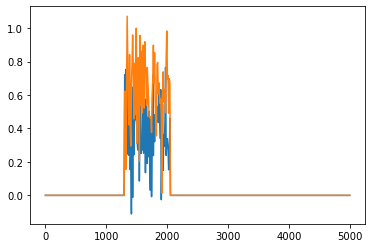

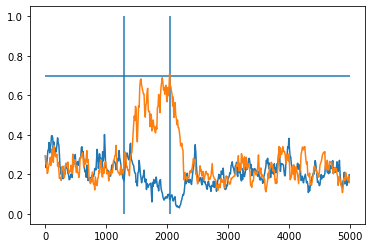

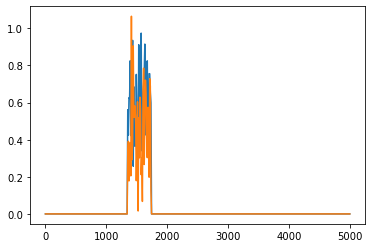

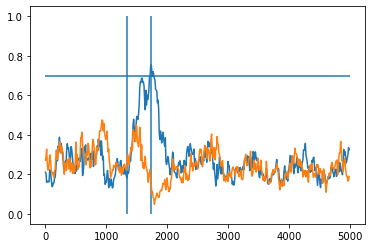

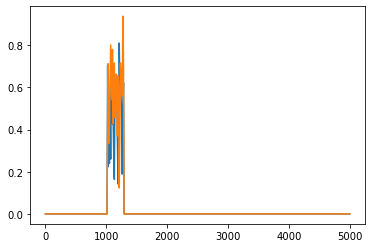

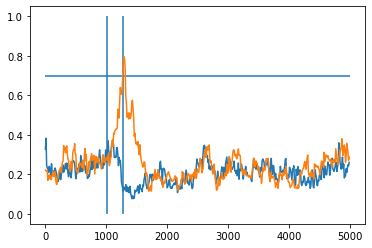

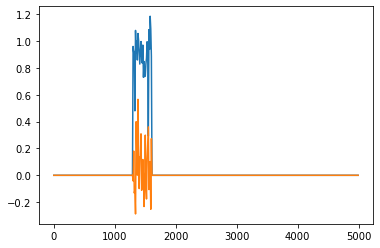

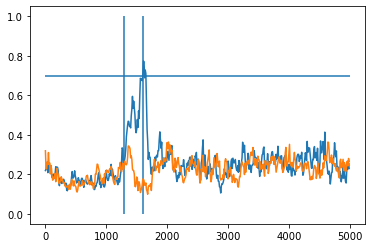

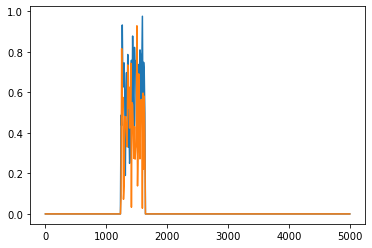

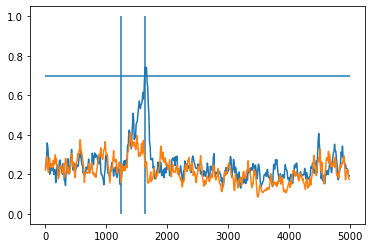

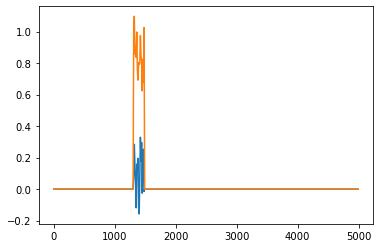

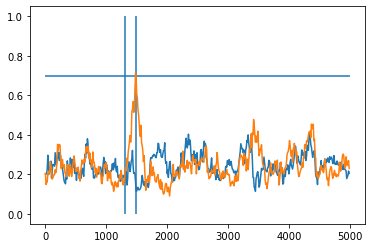

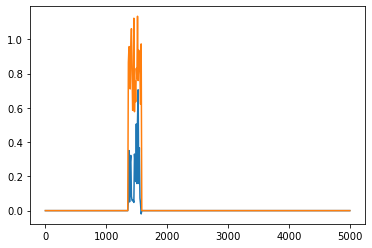

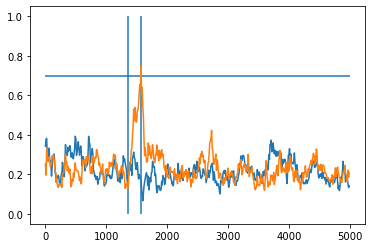

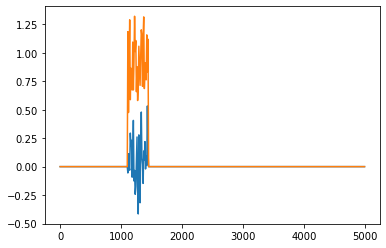

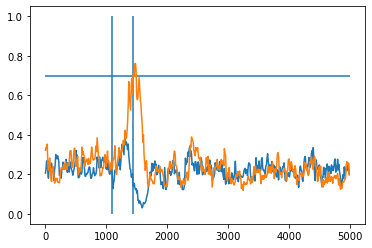

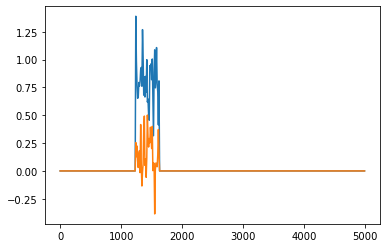

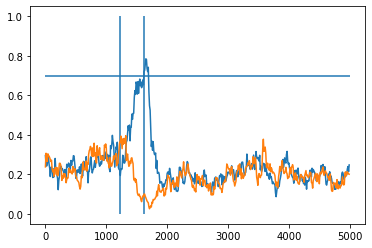

In [19]:
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10):
    plt.figure()
    plt.plot(np.arange(0, 5000, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, 5000, 10), inputs[i, :, 1])

    plt.figure()
    plt.plot(np.arange(0, 5000, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, 5000, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, 5000)

In [20]:
correct_side = (coherence > 0.5)
correct_side = 1 - 1*correct_side


checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           # the real coherence based on left and right (positive: left evidence dominant
                           # negative: right evidence dominant)
                           'coherence' : 2*coherence - 1,
                           'coherence_bin' : np.round(2*coherence - 1, 1),
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int),
                           'init_y_left' : init_y_left,
                           'init_y_right' : init_y_right})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))



Overall Accuracy: 0.9506
Negative RT trials ratio: 0.0


In [21]:
#######################
## summary result save path

resultPath = "./resultData/checkerPmdInit.csv"
checker_df.to_csv(resultPath)

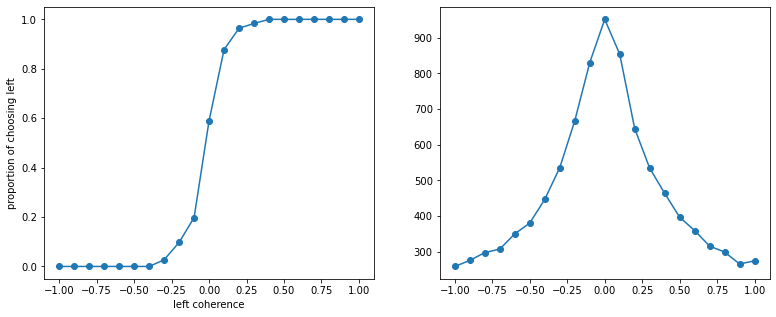

In [22]:
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], 1-checker_mean['decision'])
plt.scatter(checker_mean['coherence_bin'], 1-checker_mean['decision'])
plt.xlabel("left coherence")
plt.ylabel("proportion of choosing left")
plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



# RT within same coherence

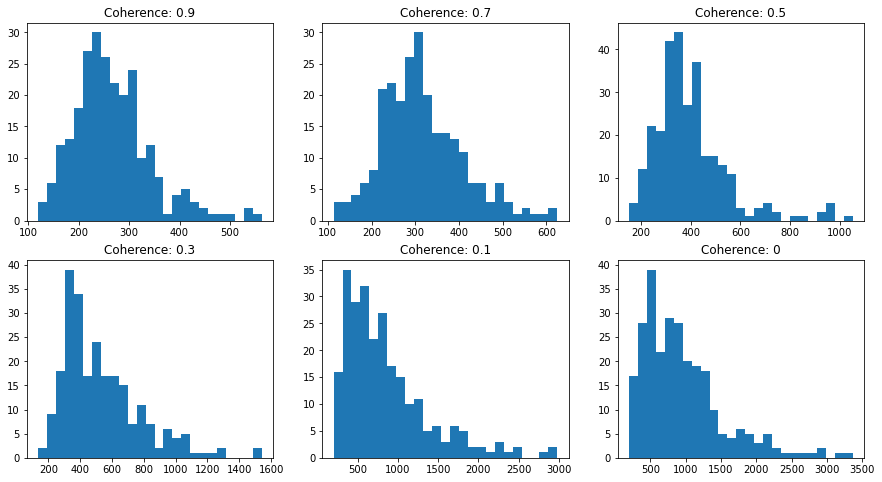

In [23]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

# Check the activity of each recurrent unit

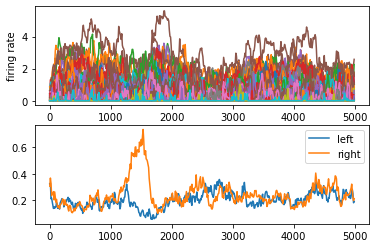

In [24]:
trial_num = 5
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left")
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,1], label = "right")
plt.legend()

# save the firing rate of of each unit and output
# trialDat = {'state':rnn_state, 'y':rnn_out}
# np.save("./stateActivityCheckerPmdInputNoise0.25.npy",trialDat)


In [25]:
# transpose the data and save as .mat file for analysis on matlab
temp = np.transpose(rnn_state, (2,1,0))
from scipy.io import savemat
mdic = {'temp': temp}
savemat("temp.mat", mdic)